In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, models, transforms
from utils import view_data
from typing import List, Tuple

In [4]:
from easydict import EasyDict as edict

In [5]:
args = edict({})
args.image_size = 240
args.batch_size = 50
args.log_interval = 100

In [6]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [7]:
transform_base =  transforms.Compose([
            transforms.Resize((int(args.image_size), int(args.image_size))),
            transforms.ToTensor(),  # Convert the image to pyTorch Tensor data type.
            transforms_norm, ])      
    

In [8]:
image_path = "../data/animal/"

image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train',
                            transform=transform_base
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test',
                          transform=transform_base
                        )
                }

In [9]:
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [10]:
data, label = next(iter(dataloader['train']))

In [11]:
data.shape

torch.Size([50, 3, 240, 240])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


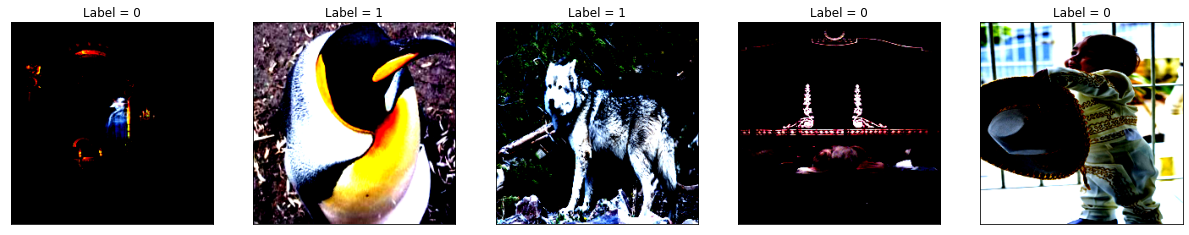

In [12]:
from utils import view_data
original = view_data(data, label, 5)

In [13]:
vgg_test = models.vgg16(pretrained=True) 

In [14]:
vgg_test

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
vgg_test.classifier[0].in_features


25088

In [16]:
def expand_dim(tensor, dim, desired_dim_len):
    sz = list(tensor.size())
    sz[dim]=desired_dim_len
    return tensor.expand(tuple(sz))

In [17]:
def kl_divergence(model, z):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(z), args.std_sched  * torch.ones_like(z))

    # 2. get the probabilities from the equation
    log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = model.LAMBDA * kl.sum()
    return kl

In [18]:
class Grid_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, LAMBDA=.1, deterministic=False):
        super(Grid_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.deterministic = deterministic
        self.LAMBDA = LAMBDA
        
        self.vgg = models.vgg16(pretrained=True) 
        
        ##  The what pathway
        
        self.num_features = self.vgg.classifier[-1].in_features
        features = list(self.vgg.classifier.children())[:-1] # Remove last layer
        #features.extend([nn.Linear(num_features, 500)]) # Add our layer
        self.vgg.classifier = nn.Sequential(*features) # Replace the model classifier
        
        self.what_grid = self.logPolarGrid(-2,-5) 
        
        n_features = torch.tensor(self.num_features, dtype=torch.float)
        
        self.fc_what = nn.Linear(self.num_features, 2)
        self.fc_what.weight.data /= torch.sqrt(n_features)
        self.fc_what.bias.data /= torch.sqrt(n_features)

        ##  The where pathway        
        self.where_grid = self.logPolarGrid(0,-3)
        
        self.where_num_features = self.vgg.classifier[0].in_features
        n_features = torch.tensor(self.where_num_features, dtype=torch.float)
           
        self.mu = nn.Linear(self.where_num_features, 2) #, bias=False)
        self.logvar = nn.Linear(self.where_num_features, 2) #, bias=False)
        
        self.mu.weight.data /= torch.sqrt(n_features)
        self.mu.bias.data /= torch.sqrt(n_features)
        
        self.logvar.weight.data /= torch.sqrt(n_features)
        self.logvar.bias.data /= torch.sqrt(n_features)

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)
    
    def logPolarGrid(self, a, b, base=2):
        rs = torch.logspace(a, b, args.image_size, base = base)
        ts = torch.linspace(0, torch.pi*2, args.image_size)
        
        grid_xs = torch.outer(rs, torch.cos(ts)) 
        grid_xs = grid_xs.unsqueeze(0).unsqueeze(3)
        grid_xs = Variable(grid_xs, requires_grad=False)

        grid_ys = torch.outer(rs, torch.sin(ts)) 
        grid_ys = grid_ys.unsqueeze(0).unsqueeze(3)
        grid_ys = Variable(grid_ys,  requires_grad=False)
        
        grid = torch.cat((grid_xs, grid_ys), 3)
        grid = expand_dim(grid, 0, args.batch_size)
        
        return grid    

    def stn(self: object, x: torch.Tensor) -> Tuple[torch.Tensor]:
    
        logPolx = x #F.grid_sample(x, self.where_grid)
        
        if self.do_stn:
            
            with torch.no_grad():
                y = self.vgg.features(logPolx)
                y = self.vgg.avgpool(y).view(-1, self.where_num_features)
                
            mu = self.mu(y)
                                   
            if self.deterministic:
                self.q = torch.distributions.Normal(mu, torch.ones_like(mu))  
                z = mu
            else:
                logvar = self.logvar(y) + 3
                sigma = torch.exp(-logvar / 2)
                self.q = torch.distributions.Normal(mu, sigma)      
                z = self.q.rsample()
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], args.image_size, args.image_size])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                   dtype=torch.float),
                                      requires_grad=False)
            theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            z = torch.tensor([0, 0],dtype=torch.float)
            z = z.unsqueeze(0).repeat(x.size()[0], 1)
           
        return x, theta, z

    def forward(self, x):
        # transform the input
        x, theta, z = self.stn(x)
        
        logPolx = F.grid_sample(x, self.what_grid)
        with torch.no_grad():
            y = self.vgg(logPolx)  
        y = self.fc_what(y)
       
        return y, theta, z

In [19]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output, theta, z = model(data)
        if model.do_stn and not model.deterministic:
            loss = loss_func(output, target) + kl_divergence(model, z)
        else:
            loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if True: #batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(dataloader['train'].dataset),
                100. * batch_idx / len(dataloader['train']), loss.item()))


def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)

            output, theta, z = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(dataloader['test'].dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(dataloader['test'].dataset),
                     100. * correct / len(dataloader['test'].dataset)))
        return correct / len(dataloader['test'].dataset)

In [20]:
lr = 1e-4
LAMBDA = 1e-6
do_stn=True
deterministic=True

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Grid_AttentionTransNet(do_stn=do_stn, deterministic=deterministic).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1) #, verbose=True)

In [ ]:
acc = []
args.epochs = 100
for epoch in range(1, args.epochs + 1):
    train(epoch, dataloader['train'])
    curr_acc = test(dataloader['test'])
    acc.append(curr_acc)

/home/dauce/.local/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


tensor([ 0.0020, -0.0055], grad_fn=<SelectBackward0>)


/home/dauce/.local/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1/100 [0/2000 (0%)]	Loss: 0.692940
tensor([ 0.0025, -0.0013], grad_fn=<SelectBackward0>)
Train Epoch: 1/100 [50/2000 (2%)]	Loss: 0.681798
tensor([-0.0040, -0.0023], grad_fn=<SelectBackward0>)
Train Epoch: 1/100 [100/2000 (5%)]	Loss: 0.671813
